In [23]:
import numpy as np
from scipy import integrate, linalg, optimize
from matplotlib import pyplot as plt 

def takagi_chen(H):
    # takagi factoriziation part
    sing_vs, Q = linalg.eigh(H) 
    
    print("eigval")
    print(sing_vs[::-1][:4])
    print("eigvec")
    print(Q[:4,-1])
    print(Q[:4,-2])
    print(Q[:4,-3])
    print(Q[:4,-4])
    print()
    print('n = ', 1501)
    print("H * v_n")
    print(np.dot(H, Q[:,-1])[:10])
    print("λ_n * v_n")
    print(np.dot(sing_vs[-1], Q[:,-1])[:10])
    print()
    print('n = ', 1500)
    print("H * v_n")
    print(np.dot(H, Q[:,-2])[:10])
    print("λ_n * v_n")
    print(np.dot(sing_vs[-2], Q[:,-2])[:10])
    print()
    
    phase_mat = np.diag(
                [np.exp(-1.j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)  
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]  
    Qp = (Qp[:, sort_array])

    return vs, Qp

def takagi_stra(N, tol=1e-13, rounding=13):
    r"""Autonne-Takagi decomposition of a complex symmetric (not Hermitian!) matrix.

    Note that singular values of N are considered equal if they are equal after np.round(values, tol).

    See :cite:`cariolaro2016` and references therein for a derivation.

    Args:
        N (array[complex]): square, symmetric matrix N
        rounding (int): the number of decimal places to use when rounding the singular values of N
        tol (float): the tolerance used when checking if the input matrix is symmetric: :math:`|N-N^T| <` tol

    Returns:
        tuple[array, array]: (rl, U), where rl are the (rounded) singular values,
            and U is the Takagi unitary, such that :math:`N = U \diag(rl) U^T`.
    """
    (n, m) = N.shape
    if n != m:
        raise ValueError("The input matrix must be square")
    if np.linalg.norm(N - np.transpose(N)) >= tol:
        raise ValueError("The input matrix is not symmetric")

    N = np.real_if_close(N)

    if np.allclose(N, 0):
        return np.zeros(n), np.eye(n)

    if np.isrealobj(N):
        # If the matrix N is real one can be more clever and use its eigendecomposition
        l, U = np.linalg.eigh(N)
        vals = np.abs(l)  # These are the Takagi eigenvalues
        phases = np.sqrt(np.complex128([1 if i > 0 else -1 for i in l]))
        Uc = U @ np.diag(phases)  # One needs to readjust the phases
        list_vals = [(vals[i], i) for i in range(len(vals))]
        list_vals.sort(reverse=True)
        sorted_l, permutation = zip(*list_vals)
        permutation = np.array(permutation)
        Uc = Uc[:, permutation]
        # And also rearrange the unitary and values so that they are decreasingly ordered
        return np.array(sorted_l), Uc

    v, l, ws = np.linalg.svd(N)
    w = np.transpose(np.conjugate(ws))
    rl = np.round(l, rounding)

    # Generate list with degenerancies
    result = []
    for k, g in groupby(rl):
        result.append(list(g))

    # Generate lists containing the columns that correspond to degenerancies
    kk = 0
    for k in result:
        for ind, j in enumerate(k):  # pylint: disable=unused-variable
            k[ind] = kk
            kk = kk + 1

    # Generate the lists with the degenerate column subspaces
    vas = []
    was = []
    for i in result:
        vas.append(v[:, i])
        was.append(w[:, i])

    # Generate the matrices qs of the degenerate subspaces
    qs = []
    for i in range(len(result)):
        qs.append(sqrtm(np.transpose(vas[i]) @ was[i]))

    # Construct the Takagi unitary
    qb = block_diag(*qs)

    U = v @ np.conj(qb)
    return rl, U

def psd(npade):
    
    b = np.zeros(2 * npade)
    mat_xi = np.zeros((2 * npade, 2 * npade))
    mat_varsigma = np.zeros((2 * npade - 1, 2 * npade - 1))
    tilde_eta_ = np.zeros(npade, dtype = complex)         # namely cpcoef in evaluatepara.f90
    pole_ = np.zeros(npade, dtype = complex)              # namely cppole in evaluatepara.f90

    for i in range(2 * npade):
        b[i] = 2 * (i) + 1

    for i in range(2 * npade):
        for j in range(2 * npade):
            if (i == j-1 or i == j+1) :
                mat_xi[i,j] = 1.0 / np.sqrt(b[i] * b[j])

    eigval_xi, eigvec_xi = np.linalg.eig(mat_xi) 
    eigval_xi = np.sort(eigval_xi)
            
    for i in range(2 * npade - 1):
        for j in range(2 * npade -1):
            if (i == j-1 or i == j+1) :
                mat_varsigma[i,j] = 1.0 / np.sqrt(b[i+1] * b[j+1])

    eigval_varsigma, eigvec_varsigma = np.linalg.eig(mat_varsigma)
    eigval_varsigma = np.sort(eigval_varsigma)

    for i in range(npade):
        pole_[i] = (0. + 2.j) / abs(eigval_xi[i])
        eigval_xi[i] = 4.0 / eigval_xi[i]**2
    for i in range(npade-1):
        eigval_varsigma[i] = 4.0 / eigval_varsigma[i]**2

    for i in range(npade):
        tilde_eta_[i] = 0.5 * npade * (2 * npade + 1)
        for j in range(i):
            tilde_eta_[i] = tilde_eta_[i] * (eigval_varsigma[j] - eigval_xi[i]) / (eigval_xi[j] - eigval_xi[i])
        for j in range(i+1,npade):
            tilde_eta_[i] = tilde_eta_[i] * (eigval_varsigma[j-1] - eigval_xi[i]) / (eigval_xi[j] - eigval_xi[i])
        tilde_eta_[i] = (-1. + 0.j) * tilde_eta_[i]
    
    return pole_, tilde_eta_

def fdt_real(omega, t):
    t = np.array([t], dtype=np.float128)
    if (omega / T) <= 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)\
              / (1.0 + np.exp( omega / T ))
    elif (omega / T) > 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun.real

def fdt_imag(omega, t):
    t = np.array([t], dtype=np.float128)
    if (omega / T) <= 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)\
              / (1.0 + np.exp( omega / T ))
    elif (omega / T) > 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun.imag

def Jfermi_exact(omega):
    if (omega / T) <= 50:
        fun = 1.0 * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)\
              / (1.0 + np.exp( omega / T ))
    elif (omega / T) > 50:
        fun = 1.0 * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)\
              / 10e+22
    return fun

def fermi_by_pade(omega):
    result = 0.5
    for j in range(num_pade):
        result = result + tilde_eta[j] / (omega / T + pole[j]) \
                        + tilde_eta[j] / (omega / T - pole[j])
    return result

def J_fit(omega, rate, eta):
    fun = 0
    for i in range(len(rate)):
        fun = fun + eta[i] / (rate[i] + 1.j * omega )
#         if omega == 11.0:
#             print("i",i)
#             print("omega", omega, "fun", fun)
#             print("eta", eta[i], "rate", rate[i]) 
#             print("value", eta[i] / (rate[i] + 1.j * omega ))
#             print()
    return fun

In [2]:
# the information of calculation paratemers
hbar = 0.658211928
omega_max = 100.0
omega_min = -100.0
omega_sample = 5000 + 1
sigma = 1
omega_plt = np.linspace(omega_min, omega_max, omega_sample)
omega = np.linspace(omega_min, omega_max, omega_sample)

time_max = 400.0
time_min = -400.0
time_sample = 4000 + 1
tt = np.linspace(time_min, time_max, time_sample)

tt_for_corr_min = 0.0
tt_for_corr_max = 10.0
time_sample_for_corr =  1000 + 1
tt_for_corr = np.linspace(tt_for_corr_min, tt_for_corr_max, time_sample_for_corr)

bath_corr_psd = np.zeros(time_sample_for_corr, dtype=complex)
bath_corr_exact = np.zeros(time_sample_for_corr, dtype = complex)
bath_corr_exact_real = np.zeros(time_sample_for_corr)
bath_corr_exact_imag = np.zeros(time_sample_for_corr)
bath_corr_exact_freq = np.zeros(omega_sample, dtype = complex)

print('Done!')

Done!


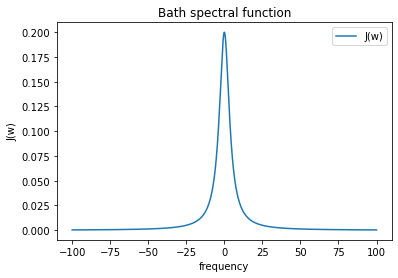

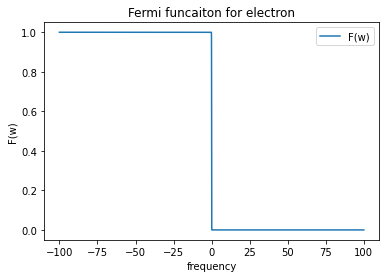

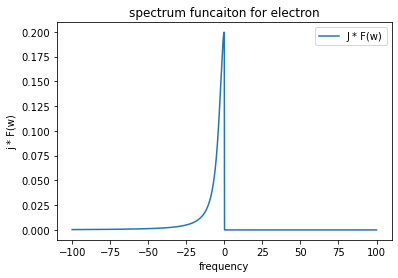

spectral_pole 
 (4+0j)
spectral_eta 
 (0.9232695124919383+0.5421567051754204j)


In [3]:
# the information of fermi funcaiton
T = 0.02              #eV
chemical_potential = 0.0 #ev

omega = omega - chemical_potential

fermi = np.zeros(omega_sample)
for i in range(omega_sample):
    if (omega[i] / (T)) <= 50 :
        fermi[i] = 1.0 / ( 1.0 + np.exp( omega[i] / (T) ) )
    elif (omega[i] / (T)) > 50 :
        fermi[i] = 1.0 / 10e+22

# the information of bath spectral funcation
# the Lorentz type J(w) = 0.5 * sys_bath_coupling * band_width**2 / ( (w + band_center)**2 + band_width**2)
sys_bath_coupling = 0.4  #eV, is equal to HEOM-QUICK
band_width = 4.0         #eV
band_center = 0.0       #eV

bath_spectral = np.zeros(omega_sample, dtype=complex)
bath_spectral = (0.5 * sys_bath_coupling * (band_width**2)) / ((omega_plt - sigma * band_center)**2 + band_width**2)
spectral_diss_rate = (band_width - 1.j * sigma * band_center) / hbar
spectral_eta = 0.5 * sys_bath_coupling * band_width \
                / ( 1.0 + np.exp((sigma * band_center + 1.j * band_width) / T )) / hbar**2

plt.title("Bath spectral function") 
plt.xlabel("frequency") 
plt.ylabel("J(w)") 
plt.plot(omega_plt, bath_spectral.real, label = 'J(w)')
plt.legend(loc=1)
plt.show()

plt.title("Fermi funcaiton for electron") 
plt.xlabel("frequency") 
plt.ylabel("F(w)") 
plt.plot(omega_plt, fermi.real, label = 'F(w)')
plt.legend(loc=1)
plt.show()

plt.title("spectrum funcaiton for electron") 
plt.xlabel("frequency") 
plt.ylabel("j * F(w)") 
plt.plot(omega_plt, bath_spectral.real * fermi.real, label = 'J * F(w)')
plt.legend(loc=1)
plt.show()


bath_corr_exact_freq = bath_spectral * fermi

print('spectral_pole \n', spectral_diss_rate * hbar)
print('spectral_eta \n', spectral_eta)


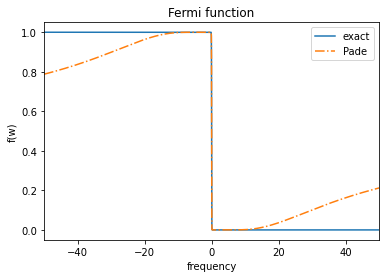

In [4]:
#the Pade scheme
num_pade = 20
tilde_eta = np.zeros(num_pade, dtype = complex)         # namely cpcoef in evaluatepara.f90 
pole = np.zeros(num_pade, dtype = complex)              # namely cppole in evaluatepara.f90

pole, tilde_eta = psd(num_pade)

if sigma == -1:
    pole = np.conj(pole)

fermi_pade = np.zeros(omega_sample, dtype = np.complex128)
for i in range(omega_sample):
    fermi_pade[i] = 0.5
    for j in range(num_pade):
        fermi_pade[i] = fermi_pade[i] + tilde_eta[j] / (omega[i] / T + pole[j]) \
                                      + tilde_eta[j] / (omega[i] / T - pole[j])


plt.title("Fermi function") 
plt.xlabel("frequency") 
plt.ylabel("f(w)") 
plt.plot(omega_plt, fermi, label = 'exact')
#plt.plot(omega, fermi_mats.real, label = 'Matsubara', linestyle = '--')
plt.plot(omega_plt, fermi_pade.real, label = 'Pade', linestyle = '-.')
plt.legend(loc=1)
plt.xlim(chemical_potential-50,chemical_potential+50)
plt.show()

In [5]:
# Here we test the nalf = 1, spin = ↑, norbs = 1 and nsgn = (+ or 1). 
# the coefficients eta and gamma only sum over the number of poles.
eta_pade = np.zeros(num_pade + 1, dtype = complex)               # namely cb in evaluatepara.f90
diss_rate_pade = np.zeros(num_pade + 1, dtype = complex)         # namely cgamma in evaluatepara.f90

spectral_diss_rate_pade = (band_width - sigma * 1.j * band_center) / hbar
spectral_eta_pade = (0.5 * sys_bath_coupling) * band_width \
                   * fermi_by_pade((1.j * spectral_diss_rate ) * hbar) / hbar**2

diss_rate_pade[0] = spectral_diss_rate_pade
eta_pade[0] = spectral_eta_pade

for i in range(1, num_pade + 1):
    diss_rate_pade[i] = (-1.j * sigma * T * pole[i - 1] ) / hbar
    eta_pade[i] = 2.j * tilde_eta[i - 1] * sys_bath_coupling * 0.5 * band_width**2 * T \
             / ( (pole[i - 1] * T - band_center)**2 + band_width**2 ) / hbar**2    
    
print('pade_diss_rate \n', -1 * diss_rate_pade * hbar)
print('pade_eta \n', eta_pade)
print('pade_eta * hbar**2 \n', eta_pade * hbar**2)

pade_diss_rate 
 [ -4.        +0.j  -0.06283185+0.j  -0.18849556+0.j  -0.31415927+0.j
  -0.43982297+0.j  -0.56548668+0.j  -0.69115038+0.j  -0.81681409+0.j
  -0.9424778 +0.j  -1.0681415 +0.j  -1.19380535+0.j  -1.31949279+0.j
  -1.44619637+0.j  -1.58443278+0.j  -1.76495399+0.j  -2.02608389+0.j
  -2.42072165+0.j  -3.05905273+0.j  -4.22944946+0.j  -6.99190012+0.j
 -20.89157037+0.j]
pade_eta 
 [0.92326951-1.84714831j 0.        -0.01846995j 0.        -0.01850649j
 0.        -0.01858j    0.        -0.01869137j 0.        -0.01884196j
 0.        -0.01903365j 0.        -0.01926888j 0.        -0.01955078j
 0.        -0.01988322j 0.        -0.02027113j 0.        -0.02073757j
 0.        -0.02180829j 0.        -0.02667792j 0.        -0.0390809j
 0.        -0.06250739j 0.        -0.11358251j 0.        -0.29333859j
 0.        +2.05236237j 0.        +0.33021021j 0.        +0.23340636j]
pade_eta * hbar**2 
 [0.4-0.80026397j 0. -0.00800197j 0. -0.0080178j  0. -0.00804965j
 0. -0.00809791j 0. -0.00816315j

In [6]:
# compare the pade results and the exact correlation function in time domain
# exact results

j = 0
for i in range(time_sample_for_corr):
    j = j + 1
    bath_corr_exact_real[i],err = integrate.quad(fdt_real, a = -100, b = 100, args=(tt_for_corr[i]), limit = 20000)
    bath_corr_exact_imag[i],err = integrate.quad(fdt_imag, a = -200, b = 200, args=(tt_for_corr[i]), limit = 10000)
    bath_corr_exact[i] = complex(bath_corr_exact_real[i], bath_corr_exact_imag[i])
    if j % 50 == 0 :
        print("run times / total times:", j ,"/", time_sample_for_corr-1, " = ", '%.2f'%(j/(time_sample_for_corr-1)))

print('Done!')

run times / total times: 50 / 1000  =  0.05


<ipython-input-6-eb8baefba233>:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  bath_corr_exact_real[i],err = integrate.quad(fdt_real, a = -100, b = 100, args=(tt_for_corr[i]), limit = 20000)


run times / total times: 100 / 1000  =  0.10
run times / total times: 150 / 1000  =  0.15
run times / total times: 200 / 1000  =  0.20
run times / total times: 250 / 1000  =  0.25
run times / total times: 300 / 1000  =  0.30
run times / total times: 350 / 1000  =  0.35
run times / total times: 400 / 1000  =  0.40
run times / total times: 450 / 1000  =  0.45
run times / total times: 500 / 1000  =  0.50
run times / total times: 550 / 1000  =  0.55
run times / total times: 600 / 1000  =  0.60
run times / total times: 650 / 1000  =  0.65
run times / total times: 700 / 1000  =  0.70
run times / total times: 750 / 1000  =  0.75
run times / total times: 800 / 1000  =  0.80
run times / total times: 850 / 1000  =  0.85
run times / total times: 900 / 1000  =  0.90
run times / total times: 950 / 1000  =  0.95
run times / total times: 1000 / 1000  =  1.00
Done!


In [7]:
# pade results
for i in range(time_sample_for_corr):
    for j in range(num_pade + 1):
        bath_corr_psd[i] = bath_corr_psd[i] + eta_pade[j] * hbar**2 * np.exp(-1 * diss_rate_pade[j] * hbar * tt_for_corr[i])

print('Done!')

Done!


In [8]:
# prony results
dimension_Hankel = 1500

tt_for_prony_min = 0.0
tt_for_prony_max = 60.0
time_sample_for_prony =  2 * dimension_Hankel + 1
tt_for_prony = np.linspace(tt_for_prony_min, tt_for_prony_max, time_sample_for_prony)
hankel_matrix_real = np.zeros((dimension_Hankel + 1, dimension_Hankel + 1))
hankel_matrix_imag = np.zeros((dimension_Hankel + 1, dimension_Hankel + 1))
phi_real = np.zeros(time_sample_for_prony)
phi_imag = np.zeros(time_sample_for_prony)

i = 0
for j in range(time_sample_for_prony):
    i = i + 1
    for k in  range(num_pade + 1):
        phi_real[j] = phi_real[j] + np.real(eta_pade[k] * hbar**2 * np.exp(-1 * diss_rate_pade[k] * hbar * tt_for_prony[j])) 
        phi_imag[j] = phi_imag[j] + np.imag(eta_pade[k] * hbar**2 * np.exp(-1 * diss_rate_pade[k] * hbar * tt_for_prony[j]))
    if i % 100 == 0 :
        print("run times / total times:", i ,"/", time_sample_for_prony-1, " = ", '%.2f'%(i/(time_sample_for_prony-1)))

for n in range(dimension_Hankel + 1):
    for m in range(dimension_Hankel + 1):
        hankel_matrix_real[n,m] = phi_real[n + m]
        hankel_matrix_imag[n,m] = phi_imag[n + m]
        
print('Done!\n')

print("hankel_matrix_real")
print(hankel_matrix_real[0,:4])
print(hankel_matrix_real[1,:4])
print(hankel_matrix_real[2,:4])
print(hankel_matrix_real[3,:4])
print()

run times / total times: 100 / 3000  =  0.03
run times / total times: 200 / 3000  =  0.07
run times / total times: 300 / 3000  =  0.10
run times / total times: 400 / 3000  =  0.13
run times / total times: 500 / 3000  =  0.17
run times / total times: 600 / 3000  =  0.20
run times / total times: 700 / 3000  =  0.23
run times / total times: 800 / 3000  =  0.27
run times / total times: 900 / 3000  =  0.30
run times / total times: 1000 / 3000  =  0.33
run times / total times: 1100 / 3000  =  0.37
run times / total times: 1200 / 3000  =  0.40
run times / total times: 1300 / 3000  =  0.43
run times / total times: 1400 / 3000  =  0.47
run times / total times: 1500 / 3000  =  0.50
run times / total times: 1600 / 3000  =  0.53
run times / total times: 1700 / 3000  =  0.57
run times / total times: 1800 / 3000  =  0.60
run times / total times: 1900 / 3000  =  0.63
run times / total times: 2000 / 3000  =  0.67
run times / total times: 2100 / 3000  =  0.70
run times / total times: 2200 / 3000  =  0.

In [24]:
sigma_real, U_real = takagi_chen(hankel_matrix_real)
sigma_imag, U_imag = takagi_chen(hankel_matrix_imag)

print(
    "error of decompose real part\n",
    np.sum(np.abs(hankel_matrix_real - np.dot(np.dot(U_real, np.diag(sigma_real)), U_real.T))), "\n"
    "error of decompose imag part\n",
    np.sum(np.abs(hankel_matrix_imag - np.dot(np.dot(U_imag, np.diag(sigma_imag)), U_imag.T))))

print('Done!')

print()
print("sigma_real")
print(sigma_real[:4])
print("U_real")
print(U_real[0,:4])
print(U_real[1,:4])
print(U_real[2,:4])
print(U_real[3,:4])
print()

eigval
[2.70533106e+00 4.44089210e-16 2.17779659e-16 1.85202058e-16]
eigvec
[-0.38452076 -0.35495739 -0.32766697 -0.30247474]
[ 0.92311635 -0.14785621 -0.13648849 -0.12599475]
[ 0.          0.32087367  0.45737945 -0.07525169]
[0.         0.26955047 0.42804333 0.06135542]

n =  1501
H * v_n
[-1.04025594 -0.96027726 -0.88644764 -0.81829431 -0.75538085 -0.69730441
 -0.6436931  -0.59420362 -0.54851908 -0.50634693]
λ_n * v_n
[-1.04025594 -0.96027726 -0.88644764 -0.81829431 -0.75538085 -0.69730441
 -0.6436931  -0.59420362 -0.54851908 -0.50634693]

n =  1500
H * v_n
[ 2.77555756e-17  5.55111512e-17  3.05311332e-16 -2.77555756e-17
  0.00000000e+00  2.77555756e-17  0.00000000e+00 -4.16333634e-17
  0.00000000e+00  0.00000000e+00]
λ_n * v_n
[ 4.09946009e-16 -6.56613479e-17 -6.06130636e-17 -5.59529098e-17
 -5.16510457e-17 -4.76799246e-17 -4.40141178e-17 -4.06301516e-17
 -3.75063571e-17 -3.46227313e-17]

eigval
[4.06695597e-01 1.78182814e-02 5.99242662e-05 1.72920377e-15]
eigvec
[0.6133478  0.44345

In [10]:
num_prony = 8

prony_roots_real = np.roots(U_real[:, num_prony][::-1])
tmp_index_real = prony_roots_real != 0
prony_roots_real = prony_roots_real[tmp_index_real]
prony_roots_real_new = prony_roots_real[np.argsort(np.abs(prony_roots_real))[:num_prony]]

print('Done!')

Done!


In [11]:
prony_roots_imag = np.roots(U_imag[:, num_prony][::-1])
tmp_index_imag = prony_roots_imag != 0
prony_roots_imag = prony_roots_imag[tmp_index_imag]
prony_roots_imag_new = prony_roots_imag[np.argsort(np.abs(prony_roots_imag))[:num_prony]]
a = np.argsort(np.abs(prony_roots_imag))[:num_prony]

print('Done!')

Done!


In [12]:
# plt.title("distrubition of roots of Re[C(t)]") 
# plt.xlabel("Re Φ") 
# plt.ylabel("Im Φ")
# plt.scatter(prony_roots_real.real, prony_roots_real.imag)
# plt.scatter(prony_roots_real_new.real, prony_roots_real_new.imag)
# plt.show()

# print(prony_roots_real_new)

# plt.title("distrubition of roots of Im[C(t)]") 
# plt.xlabel("Re Φ") 
# plt.ylabel("Im Φ")
# plt.scatter(prony_roots_imag.real, prony_roots_imag.imag)
# plt.scatter(prony_roots_imag_new.real, prony_roots_imag_new.imag)
# plt.show()

# print(prony_roots_imag_new)

In [13]:
omega_matrix_real = np.zeros((time_sample_for_prony, num_prony), dtype=complex)
for i in range(time_sample_for_prony):
    for j in range(num_prony):
        omega_matrix_real[i, j] = prony_roots_real_new[j]**i
eta_prony_real_tmp = np.dot(linalg.inv(np.dot(omega_matrix_real.T, omega_matrix_real)), np.dot(omega_matrix_real.T, phi_real))

omega_matrix_imag = np.zeros((time_sample_for_prony, num_prony), dtype=complex)
for i in range(time_sample_for_prony):
    for j in range(num_prony):
        omega_matrix_imag[i, j] = prony_roots_imag_new[j]**i
eta_prony_imag_tmp = np.dot(linalg.inv(np.dot(omega_matrix_imag.T, omega_matrix_imag)), np.dot(omega_matrix_imag.T, phi_imag))

print('Done!')

Done!


In [14]:
# plt.title("distrubition of part roots") 
# plt.xlabel("Re Φ") 
# plt.ylabel("Im Φ")
# plt.scatter(np.real(eta_prony_real_tmp),np.imag(eta_prony_real_tmp), label = 'real')
# plt.scatter(np.real(eta_prony_imag_tmp),np.imag(eta_prony_imag_tmp), label = 'imag')
# plt.show()

In [15]:
bath_corr_prony = np.zeros(time_sample_for_corr, dtype=complex)

diss_rate_prony_real_tmp =  -2 * dimension_Hankel \
                            / tt_for_prony_max * ( np.log( np.abs( prony_roots_real_new ) ) + 1.j * np.angle(prony_roots_real_new) )
diss_rate_prony_imag_tmp =  -2 * dimension_Hankel \
                            / tt_for_prony_max * ( np.log( np.abs( prony_roots_imag_new ) ) + 1.j * np.angle(prony_roots_imag_new) )

eta_prony = np.zeros(2 * num_prony , dtype = complex)
diss_rate_prony = np.zeros(2 * num_prony, dtype = complex)

eta_prony[0:num_prony] = eta_prony_imag_tmp * 1.j
eta_prony[num_prony:2 * num_prony] = eta_prony_real_tmp

diss_rate_prony[0:num_prony] = diss_rate_prony_imag_tmp
diss_rate_prony[num_prony:2*num_prony] = diss_rate_prony_real_tmp

for i in range(time_sample_for_corr):
    for j in range(2 * num_prony):
        bath_corr_prony[i] = bath_corr_prony[i] + eta_prony[j] * np.exp(-1 * diss_rate_prony[j] * tt_for_corr[i])

print("diss_rate_prony\n",diss_rate_prony)
print("eta_prony\n",eta_prony)

print('Done!')

diss_rate_prony
 [20.62944854-5.45507932e-16j  6.13538872+3.22865325e-14j
  2.65400245-1.39296351e-13j  1.19458117+1.47718722e-13j
  0.54613036-1.84770624e-14j  0.25414097+8.10921600e-15j
  0.15806823-8.66497735e-14j  0.06264743+1.48629488e-13j
 53.51311107-0.00000000e+00j 14.9420321 -7.14080471e+01j
 14.9420321 +7.14080471e+01j  7.52966203+2.51364285e-15j
  4.        -1.47934211e-14j  1.3102232 -1.29408269e+02j
  1.3102232 +1.29408269e+02j -0.63917233-8.39854322e+01j]
eta_prony
 [-1.02064323e-14+1.04179635e-01j  4.50941868e-14+2.56942656e-01j
 -7.04175855e-14-2.44661446e-01j  7.52062422e-14-6.58818935e-02j
 -1.01513222e-13-2.75322505e-02j  1.67185801e-13-1.17503398e-02j
 -1.49896063e-13-3.40500762e-03j  4.34876647e-14-7.91450637e-03j
  3.85887495e-15-1.14870194e-15j  2.82977318e-17+2.48614782e-16j
 -5.25596618e-16+9.27021533e-17j  1.04887916e-14+3.82960877e-15j
  4.00000000e-01-3.28368413e-15j -7.02698051e-17+4.24645275e-18j
 -6.94646498e-17+1.67689017e-17j  1.36845553e-48+6.41463530e

In [16]:
#the Pade scheme
num_pade_small = num_prony * 2
tilde_eta_small = np.zeros(num_pade_small, dtype = complex)         # namely cpcoef in evaluatepara.f90 
pole_small = np.zeros(num_pade_small, dtype = complex)              # namely cppole in evaluatepara.f90
bath_corr_psd_small = np.zeros(time_sample_for_corr, dtype = complex)

pole_small, tilde_eta_small = psd(num_pade_small)

if sigma == -1:
    pole_small = np.conj(pole_small)

# Here we test the nalf = 1, spin = ↑, norbs = 1 and nsgn = (+ or 1). 
# the coefficients eta and gamma only sum over the number of poles.
eta_pade_small = np.zeros(num_pade_small + 1, dtype = complex)               # namely cb in evaluatepara.f90
diss_rate_pade_small = np.zeros(num_pade_small + 1, dtype = complex)         # namely cgamma in evaluatepara.f90

diss_rate_pade_small[0] = spectral_diss_rate_pade
eta_pade_small[0] = spectral_eta_pade

for i in range(1, num_pade_small + 1):
    diss_rate_pade_small[i] = (-1.j * sigma * T * pole_small[i - 1]) / hbar
    eta_pade_small[i] = 2.j * tilde_eta_small[i - 1] * sys_bath_coupling * 0.5 * band_width**2 * T \
             / ( (pole_small[i - 1] * T - band_center)**2 + band_width**2 ) / hbar**2    

print('pade_diss_rate \n', -1 * diss_rate_pade_small * hbar)
print('pade_eta \n', eta_pade_small)
print('pade_eta * hbar**2 \n', eta_pade_small * hbar**2)

# pade results
for i in range(time_sample_for_corr):
    for j in range(num_pade_small + 1):
        bath_corr_psd_small[i] = bath_corr_psd_small[i] + eta_pade_small[j] * hbar**2 * np.exp(-1 * diss_rate_pade_small[j] * hbar * tt_for_corr[i])

print('Done!')

pade_diss_rate 
 [ -4.        +0.j  -0.06283185+0.j  -0.18849556+0.j  -0.31415927+0.j
  -0.43982297+0.j  -0.56548668+0.j  -0.69115038+0.j  -0.81681409+0.j
  -0.94247852+0.j  -1.06826391+0.j  -1.19800057+0.j  -1.35737091+0.j
  -1.59839807+0.j  -1.99839244+0.j  -2.74278292+0.j  -4.51338309+0.j
 -13.45583455+0.j]
pade_eta 
 [0.92326951-1.84714831j 0.        -0.01846995j 0.        -0.01850649j
 0.        -0.01858j    0.        -0.01869137j 0.        -0.01884196j
 0.        -0.01903365j 0.        -0.01926889j 0.        -0.01955146j
 0.        -0.01996716j 0.        -0.02217541j 0.        -0.0316217j
 0.        -0.05302838j 0.        -0.10253586j 0.        -0.29198049j
 0.        +1.59568568j 0.        +0.38273175j]
pade_eta * hbar**2 
 [0.4-0.80026397j 0. -0.00800197j 0. -0.0080178j  0. -0.00804965j
 0. -0.00809791j 0. -0.00816315j 0. -0.00824619j 0. -0.00834811j
 0. -0.00847053j 0. -0.00865063j 0. -0.00960734j 0. -0.01369988j
 0. -0.02297417j 0. -0.04442294j 0. -0.12649849j 0. +0.69131956j

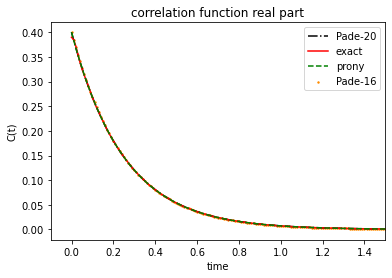

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19]
[0.4        0.38431578 0.36924654 0.35476817 0.34085752 0.3274923
 0.31465114 0.3023135  0.29045961 0.27907053 0.26812802 0.25761457
 0.24751336 0.23780822 0.22848363 0.21952465 0.21091697 0.2026468
 0.1947009  0.18706657]


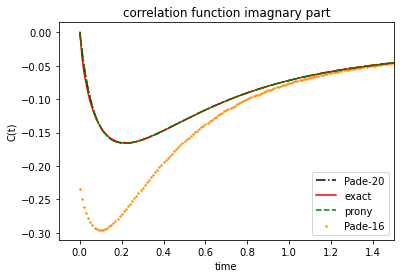

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19]
[ 4.44089210e-16 -2.73631624e-02 -5.03552419e-02 -6.97082990e-02
 -8.60230553e-02 -9.97932139e-02 -1.11425223e-01 -1.21254339e-01
 -1.29557691e-01 -1.36564897e-01 -1.42466708e-01 -1.47422040e-01
 -1.51563701e-01 -1.55003050e-01 -1.57833804e-01 -1.60135134e-01
 -1.61974199e-01 -1.63408211e-01 -1.64486126e-01 -1.65250028e-01]


In [17]:
plt.title("correlation function real part") 
plt.xlabel("time") 
plt.ylabel("C(t)") 
plt.plot(tt_for_corr, bath_corr_psd.real, label = 'Pade-%d' %num_pade, linestyle = '-.', color = 'k') 
plt.scatter(tt_for_corr, bath_corr_psd_small.real, label = 'Pade-%d' %num_pade_small, s = 2, color = 'darkorange') 
plt.plot(tt_for_corr, bath_corr_exact_real / np.pi, label = 'exact', color = 'r') 
plt.plot(tt_for_corr, bath_corr_prony.real, label = 'prony', linestyle = '--', color = 'g')
plt.legend(loc=1)
plt.xlim(-0.1, 1.5)
plt.show()

print(tt_for_corr[:20])
print(bath_corr_psd[:20].real)

plt.title("correlation function imagnary part") 
plt.xlabel("time") 
plt.ylabel("C(t)") 
plt.plot(tt_for_corr, bath_corr_psd.imag, label = 'Pade-%d' %num_pade, linestyle = '-.', color = 'k') 
plt.scatter(tt_for_corr, bath_corr_psd_small.imag, label = 'Pade-%d' %num_pade_small, s = 2, color = 'darkorange') 
plt.plot(tt_for_corr, bath_corr_exact_imag / np.pi, label = 'exact', color = 'r') 
plt.plot(tt_for_corr, bath_corr_prony.imag, label = 'prony', linestyle = '--', color = 'g')
plt.legend(loc=4)
plt.xlim(-0.1, 1.5)
plt.show()

print(tt_for_corr[:20])
print(bath_corr_psd[:20].imag)

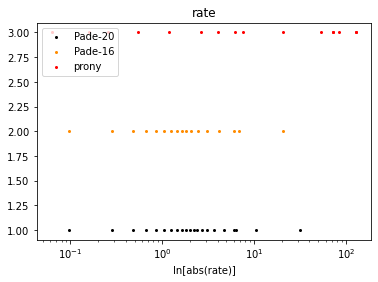

In [18]:
one = np.ones(len(diss_rate_pade))
two =  np.ones(len(diss_rate_pade_small)) * 2
three =  np.ones(len(diss_rate_prony)) * 3
plt.title("rate") 
plt.xlabel("ln[abs(rate)]") 
plt.ylabel("") 
plt.scatter(np.abs(diss_rate_pade), one, label = 'Pade-%d' %num_pade, s = 4, color = 'k') 
plt.scatter(np.abs(diss_rate_pade_small), two, label = 'Pade-%d' %num_pade_small, s = 4, color = 'darkorange') 
plt.scatter(np.abs(diss_rate_prony), three, label = 'prony', s = 4, color = 'r') 
plt.legend(loc=2)
plt.xscale("log")
#plt.xlim(-0.1, 1.5)
plt.show()

In [19]:
bath_corr_psd_freq = np.zeros(omega_sample, dtype = complex)
bath_corr_psd_small_freq = np.zeros(omega_sample, dtype = complex)
#bath_corr_prony_imag_freq = np.zeros(omega_sample, dtype = complex)
#bath_corr_prony_real_freq = np.zeros(omega_sample, dtype = complex)
bath_corr_prony_freq = np.zeros(omega_sample, dtype = complex)

for i in range(omega_sample):
    #bath_corr_psd_freq[i] =   Jfermi_psd(omega_freq[i])
    bath_corr_psd_small_freq[i] = J_fit(omega[i], diss_rate_pade_small * hbar, eta_pade_small * hbar**2)
    bath_corr_psd_freq[i] = J_fit(omega[i], diss_rate_pade * hbar, eta_pade * hbar**2)
    bath_corr_prony_freq[i] = J_fit(omega[i], diss_rate_prony, eta_prony)
    #bath_corr_prony_imag_freq[i] = J_fit(omega_freq[i], diss_rate_prony_imag, eta_prony_imag)
    #bath_corr_prony_real_freq[i] = J_fit(omega_freq[i], diss_rate_prony_real, eta_prony_real)

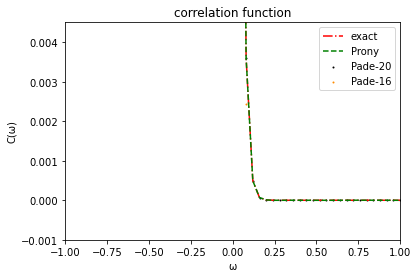

 -0.03999999999999204 
 psd   0.17614180141542582 
 exact 0.1761418014154266 
 prony 0.17614060588931862
 small 0.17672768619866314

 0.0 
 psd   0.1 
 exact 0.1 
 prony 0.09999999999997285
 small 0.1

 0.04000000000000625 
 psd   0.023838200584359263 
 exact 0.02383820058435851 
 prony 0.02383939611051064
 small 0.02325231580112177


In [20]:
plt.title("correlation function") 
plt.xlabel("ω") 
plt.ylabel("C(ω)")
plt.scatter(omega_plt, bath_corr_psd_freq.real, label = 'Pade-%d'%num_pade, s = 1, color = 'k')
plt.scatter(omega_plt, bath_corr_psd_small_freq.real, label = 'Pade-%d'%num_pade_small, s = 1, color = 'darkorange')
plt.plot(omega_plt, bath_corr_exact_freq.real, label = 'exact', linestyle = '-.', color = 'r')
plt.plot(omega_plt, bath_corr_prony_freq.real, label = 'Prony', linestyle = '--', color = 'g')
plt.legend(loc=1)
plt.xlim(-1, 1)
plt.ylim(-0.001, 0.0045)
plt.show()

x = 2500
a = max(np.abs(bath_corr_psd_freq.real))
b = max(np.abs(bath_corr_exact_freq.real))
c = max(np.abs(bath_corr_prony_freq.real))
print('',omega_plt[x-1],'\n psd  ',(bath_corr_psd_freq[x-1]).real,'\n exact',bath_corr_exact_freq[x-1],\
      '\n prony',(bath_corr_prony_freq[x-1]).real)
print(' small', bath_corr_psd_small_freq[x-1].real)
print()
print('',omega_plt[x],'\n psd  ',(bath_corr_psd_freq[x]).real,'\n exact',bath_corr_exact_freq[x],\
      '\n prony',(bath_corr_prony_freq[x]).real)
print(' small', bath_corr_psd_small_freq[x].real)
print()
print('',omega_plt[x+1],'\n psd  ',(bath_corr_psd_freq[x+1]).real,'\n exact',bath_corr_exact_freq[x+1],\
      '\n prony',(bath_corr_prony_freq[x+1]).real)
print(' small', bath_corr_psd_small_freq[x+1].real)